In [1]:

#### 最初に必要なライブラリを読み込みます。
from sympy import *
from sympy.physics.quantum import *
from sympy.physics.quantum.qubit import Qubit, QubitBra, measure_all, measure_all_oneshot,measure_partial, matrix_to_qubit
from sympy.physics.quantum.gate import H,X,Y,Z,S,T,CPHASE,CNOT,SWAP,UGate,CGateS,gate_simp,OneQubitGate
from sympy.physics.quantum.gate import IdentityGate as _I
from sympy.physics.quantum.qft import *
from sympy.physics.quantum.matrixcache import matrix_cache
matrix_cache.cache_matrix('Tdg',Matrix([[1, 0], [0, exp(-I*pi/4)]]))
matrix_cache.cache_matrix('Sdg',Matrix([[1, 0], [0, -I]]))
matrix_cache.cache_matrix('V',(1/2)*Matrix([[1+I, 1-I], [1-I, 1+I]]))
matrix_cache.cache_matrix('Vdg',(1/2)*Matrix([[1-I, 1+I], [1+I, 1-I]]))

CZ = CPHASE

class Tdg(OneQubitGate): # T^{\dagger} 演算
    gate_name = u'Tdg'
    gate_name_latex = u'T^{\dagger}'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('Tdg', format)

class Sdg(OneQubitGate): # S^{\dagger} 演算
    gate_name = u'Sdg'
    gate_name_latex = u'S^{\dagger}'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('Sdg', format)

class V(OneQubitGate): # √X 演算
    gate_name = u'V'
    gate_name_latex = u'V'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('V', format)

class Vdg(OneQubitGate): # √X ^{\dagger}演算
    gate_name = u'Vdg'
    gate_name_latex = u'V^{\dagger}'
    def get_target_matrix(self, format='sympy'):
        return matrix_cache.get_matrix('Vdg', format)

def CV(c,t):  return CGateS((c),V(t))
def CVdg(c,t):  return CGateS((c),Vdg(t))

def CCX(c1,c2,t):  return CGateS((c1,c2),X(t))
def Toffoli(c1,c2,t):  return CGateS((c1,c2),X(t))
def CCZ(c1,c2,t): return (H(t)*CCX(c1,c2,t)*H(t)) # CCZ演算子を定義します。
def hadamard(s,n):
    h = H(s)
    for i in range(s+1,n+s): h = H(i)*h
    return h

def disp1Q(u): print(u); display(represent(u,nqubits=1)); CircuitPlot(u,nqubits=1)
def disp2Q(u): print(u); display(represent(u,nqubits=2)); CircuitPlot(u,nqubits=2)

from sympy.printing.dot import dotprint
init_printing()

%matplotlib inline
import matplotlib.pyplot as plt
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller, Mz,CreateOneQubitGate
alpha, beta, gamma, delta = Symbol(r'\alpha'), Symbol(r'\beta'), Symbol(r'\gamma'), Symbol(r'\delta'), 
psi, phi, theta, chi = Symbol(r'\psi'), Symbol(r'\phi'), Symbol(r'\theta'), Symbol(r'\chi') 
from qutip import *
import numpy as np


（副読本）
* ニールセン・チャン「量子コンピュータと量子通信」（ここでは N,C"QCQI" と書きます）
* arXivに公開されている論文

## 4.2 量子化学計算

この章は、量子化学計算の基礎的な知識が前提となっていると感じました。  
以下に各節の概略（読むための道しるべ？）をまとめます。


### 4.2.1 行列の固有値問題として解く

→p.73 の「3.6 量子力学をシミュレーションする」も参照

$ \displaystyle i\hbar\frac{\partial \psi (r,t) }{\partial t} = \mathcal{H}  \psi (r,t) $

量子化学計算　＝　電子の配置　と　エネルギー　を求める　＝　大規模な行列の固有値問題

いかに精密に近似計算するか？

Born-Oppenhimer 近似 → スレーター行列を用いた Hartree-Fock法　


$\mathcal{H}$が時間依存しない（＝tを含まない）場合は、$ \psi (t) =  e ^ \frac { - i \mathcal{H} t } { \hbar } \psi _{0}$ を左辺に代入して

$
\begin{aligned}
i \hbar \frac { \partial } { \partial t } \psi (t) &= i \hbar \frac { \partial } { \partial t } \left( \exp{ \left(  \frac { - i \mathcal{H} t } { \hbar } \right) } \right) \psi _{0} \\
&= i \hbar \left( \frac {- i  \mathcal{H} } { \hbar } \exp{ \left( \frac { - i  \mathcal{H} t } { \hbar } \right) } \right) \psi _{0} \\
&= \mathcal{H} \exp{ \left(\frac { -i \mathcal{H} t } { \hbar } \right) } \psi _{0} 
\end{aligned}
$

となり、ハミルトニアンはエルミート演算子（＊）なので、都合のよいユニタリ演算子の形がでてきます。

（＊）「ある物理量に対応する演算子がエルミートであれば、実数の観測値を持つ」ことから、ハミルトニアンはエルミート演算子であるとします。

量子コンピュータは、ユニタリ演算子の積の計算は得意

$ U_{t} \dots U_{2} \cdot U_{1} \psi _{0} $

ハミルトニアンは多項式で、足し算で表されているとすると、和を積で表すことができると嬉しい。
演算子の表現として行列で表されますが、一般に、演算子（＝行列）は交換則が成り立ちません。

つまり、いま $ e ^ {A+B} $ という行列を考えるときに、一般には $ e ^ {A+B } \neq e ^{A} \cdot e ^{B} $ です。

単純には、和を積にはできませんが、リー・トロッター公式が示されているので「トロッター分解」により、和を積で”近似的に”表すことができます。

### 3.6.2 変分法で最適化問題に帰着して解く

《keywords》

* 変分法
* ansatz　（試行状態、試行波動関数）　　　

　　お試しのための状態関数、勾配法などの最適化アルゴリズムをつかうためのパラメータを含む
  
NISQによる「量子・古典ハイブリッド」なアルゴリズム  
量子化学計算に適応すると「VQE （Variational Quantum Eigensolver）」 p.144  
イジングモデルにして0-1整数計画問題の最適化に適応した「QAOA（Quantum Approximate Optimization Algorithm）」 p.148

## 3.7 データ行列を扱う


行列 $A$ を密度行列 $\rho$ にエンコードして、その冪で書ける $ e ^ {i \rho t } $ 演算子を量子状態　$\sigma$　に作用させる

つまり、 $ e ^ {-i \rho t } \sigma e ^ { i \rho t }$ を考えることになる

これは、  $ e ^ {-i \rho t } \sigma e ^ { i \rho t } \approx \sigma - i ( \sigma \rho - \rho \sigma) $ と近似できる

これを計算するために、次元を広げて２つの密度行列の直積 $\rho \otimes \sigma$ の状態に対して、任意の量子ビットのSWAPゲートの和 $ S $ を用いた演算子 $ e ^ {i S t} $ を導入する。

すると、 $ e ^ {-i S t } ( \rho \otimes \sigma  ) e ^ { i S t }$ の　$ \rho $ のあった量子ビットについての部分トレースで計算ができる。

すなわち

$ e ^ {-i \rho t } \sigma e ^ { i \rho t }　\approx　Tr _{P} \left[ e ^ {-i S t } ( \rho \otimes \sigma  ) e ^ { i S t } \right]$

* 演算子  $𝑒^{𝑖𝑆𝑡}$ について

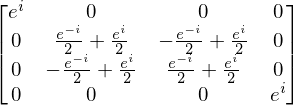

In [2]:
# t をつけると　sympy のエラーとなるため、t は省いて計算してみる
exp(I*Matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]))

t をつけると上記は

$\displaystyle
\left[\begin{matrix}e^{it} & 0 & 0 & 0\\0 & \cos{t} & i \sin{t} & 0\\0 & i \sin{t} & cos{t} & 0\\0 & 0 & 0 & e^{it}\end{matrix}\right] 
\sim \left[\begin{matrix}1 & 0 & 0 & 0\\0 & 1+ \frac{e^{- 2it}}{2}  & 1 - \frac{e^{- 2it}}{2} & 0\\0 & 1  - \frac{e^{- 2it}}{2}  & 1 +\frac{e^{- 2it}}{2}& 0\\0 & 0 & 0 & 1\end{matrix}\right]$

右辺は、グローバル位相 $e^{it}$ を省いた式

$t=-\frac{\pi}{4}$のとき、$\sqrt{SWAP}$ゲートがこれに相当します

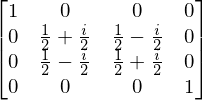

In [3]:
SQSW = S(1)*Sdg(0)*CNOT(0,1)*H(0)*Tdg(0)*CNOT(1,0)*Tdg(1)*T(0)*H(0)*CNOT(0,1)
simplify(represent(SQSW,nqubits=2))

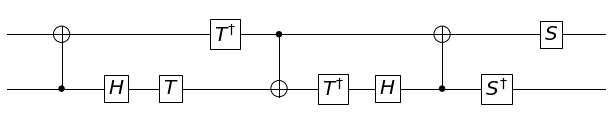

In [4]:
CircuitPlot(SQSW,nqubits=2)

# 第4章 量子アルゴリズム

[Quantum Algorithm Zoo](https://quantumalgorithmzoo.org/)

日本語翻訳サイト（Qmedia)： https://www.qmedia.jp/algorithm-zoo/

## 4.1 素因数分解（ショアのアルゴリズム）
### 4.1.1 位数発見問題として解く

<img src="image0.png" align="left" width="250" />
（１）古典コンピューターによる前処理

問題となる自然数 $ N $ より小さい、$ N $ と互いに素<sup>(*)</sup>である適当な $ a $ を選択する処理です。　<br/>
この処理で、$ N $ を割り切る因数がたまたま見つかることもあり、そのときは、以降の処理は不要となります。<br/>


（２）量子コンピューターによる処理

（１）で選択した $ a $ を使った「関数：$ f(x) = a^x\pmod{N} $」を入力にして、周期 $ T $ を発見するための処理です。　<br/>
この処理の出力は、あとで周期 $ T $ を計算で求められるような確率密度関数 $ P_T(x) $ です。<br/>

（３）古典コンピューターによる後処理

確率密度関数 $ P_T(x) $ から $ T $ を計算し、それが偶数かどうかを判定します。　<br/>
$ T $ が奇数であれば、（１）からやり直します。<br/>
$ T $ が偶数であれば、$ a^{T/2} \pm 1 $ と $ N $ が互いに素<sup>(*)</sup>か調べます。　<br/>
互いに素であれば、（１）からやり直します。　<br/>
互いに素でなければ、因数が求められます。　<br/>

### 4.1.2  量子位数発見サブルーチン

<img src="image1.png" width="70%" />

<img src="image2.png" width="70%" />

<img src="image3.png" width="70%" />

位相推定が使えます

<img src="image4.png" width="70%" />